In [17]:
import numpy as np
import scipy.sparse as sp
import networkx as nx
from networkx.linalg.algebraicconnectivity import algebraic_connectivity
import pandas as pd
import json 

HYPERGRAPH_FOLDER = "../Gen_Hypergraph/output/DGIDB_BIPOLAR/" 
DGIDB = pd.read_csv("../Data/DGIDB/DrugToGene.tsv", sep="\t")

In [18]:
H = sp.load_npz(HYPERGRAPH_FOLDER + "hypergraph_incidence_matrix_binary.npz")
A = H @ H.T
# Remove self-loops (set diagonal to 0)
A.setdiag(0)

# Convert to NetworkX graph
G = nx.from_scipy_sparse_matrix(A)

c:\Users\richa\Desktop\CodingWorkspaces\DGI-Hypergraph-Fin\dgivenv\lib\site-packages\scipy\sparse\_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [19]:

# Extract largest connected component (LCC)
largest_cc = max(nx.connected_components(G), key=len)
G_lcc = G.subgraph(largest_cc).copy()

# Basic properties
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
avg_degree = sum(dict(G.degree()).values()) / num_nodes
density = nx.density(G)
num_components = nx.number_connected_components(G)
largest_cc_size = len(largest_cc)

# Path & structure properties (only LCC)
diameter_lcc = nx.diameter(G_lcc)
avg_shortest_path_lcc = nx.average_shortest_path_length(G_lcc)

# Clustering and transitivity
avg_clustering = nx.average_clustering(G)
transitivity = nx.transitivity(G)

# Centrality measures
degree_centrality = nx.degree_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000)
pagerank = nx.pagerank(G)

# Assortativity
degree_assortativity = nx.degree_assortativity_coefficient(G)

# Spectral properties
algebraic_conn = algebraic_connectivity(G)

# Utility function: top n from centrality dict
def top_n(d, n=5):
    return sorted(d.items(), key=lambda x: x[1], reverse=True)[:n]

# Print all metrics
print("====== Gene-Gene Network Metrics ======\n")
print(f"Number of nodes: {num_nodes}")
print(f"Number of edges: {num_edges}")
print(f"Average degree: {avg_degree:.4f}")
print(f"Density: {density:.6f}")
print(f"Number of connected components: {num_components}")
print(f"Largest connected component size: {largest_cc_size}")
print(f"Diameter (LCC): {diameter_lcc}")
print(f"Average shortest path length (LCC): {avg_shortest_path_lcc:.4f}")
print(f"Average clustering coefficient: {avg_clustering:.4f}")
print(f"Transitivity (global clustering): {transitivity:.4f}")
print(f"Degree assortativity coefficient: {degree_assortativity:.4f}")
print(f"Algebraic connectivity: {algebraic_conn:.4f}")

print("\nTop 5 nodes by degree centrality:")
for node, score in top_n(degree_centrality):
    print(f"  Node {node}: {score:.4f}")

print("\nTop 5 nodes by closeness centrality:")
for node, score in top_n(closeness_centrality):
    print(f"  Node {node}: {score:.4f}")

print("\nTop 5 nodes by betweenness centrality:")
for node, score in top_n(betweenness_centrality):
    print(f"  Node {node}: {score:.4f}")

print("\nTop 5 nodes by eigenvector centrality:")
for node, score in top_n(eigenvector_centrality):
    print(f"  Node {node}: {score:.4f}")

print("\nTop 5 nodes by PageRank:")
for node, score in top_n(pagerank):
    print(f"  Node {node}: {score:.4f}")

====== Gene-Gene Network Metrics ======

Number of nodes: 4774
Number of edges: 17528
Average degree: 7.3431
Density: 0.001538
Number of connected components: 4440
Largest connected component size: 335
Diameter (LCC): 3
Average shortest path length (LCC): 1.8253
Average clustering coefficient: 0.0621
Transitivity (global clustering): 0.6674
Degree assortativity coefficient: 0.3298
Algebraic connectivity: 0.0000

Top 5 nodes by degree centrality:
  Node 85: 0.0532
  Node 97: 0.0511
  Node 0: 0.0509
  Node 820: 0.0509
  Node 934: 0.0497

Top 5 nodes by closeness centrality:
  Node 85: 0.0562
  Node 97: 0.0549
  Node 0: 0.0547
  Node 820: 0.0547
  Node 934: 0.0540

Top 5 nodes by betweenness centrality:
  Node 85: 0.0004
  Node 97: 0.0004
  Node 0: 0.0002
  Node 820: 0.0002
  Node 934: 0.0002

Top 5 nodes by eigenvector centrality:
  Node 820: 0.1216
  Node 934: 0.1200
  Node 935: 0.1200
  Node 31: 0.1163
  Node 518: 0.1150

Top 5 nodes by PageRank:
  Node 85: 0.0039
  Node 97: 0.0037
  N

In [20]:
df_degree = pd.DataFrame(degree_centrality.items(), columns=["node", "score"]).sort_values("score", ascending=False).reset_index(drop=True)
df_closeness = pd.DataFrame(closeness_centrality.items(), columns=["node", "score"]).sort_values("score", ascending=False).reset_index(drop=True)
df_betweenness = pd.DataFrame(betweenness_centrality.items(), columns=["node", "score"]).sort_values("score", ascending=False).reset_index(drop=True)
df_eigenvector = pd.DataFrame(eigenvector_centrality.items(), columns=["node", "score"]).sort_values("score", ascending=False).reset_index(drop=True)
df_pagerank = pd.DataFrame(pagerank.items(), columns=["node", "score"]).sort_values("score", ascending=False).reset_index(drop=True)

In [21]:
# Load the JSON data from the file
with open(HYPERGRAPH_FOLDER + 'gene_to_index.json', 'r') as file:
    gene_to_index = json.load(file)

# Invert the dictionary to map indices back to genes
index_to_gene = {v: k for k, v in gene_to_index.items()}
def get_gene_claim_name(ncbi_gene_id):
    ncbi_gene_id = int(ncbi_gene_id)
    result = DGIDB[(DGIDB['ncbi_gene_id']) == ncbi_gene_id]
    if not result.empty:
        return result['gene_name'].values[0]
    else:
        return "Gene name not found"

In [22]:
def enrich_and_save(df, name):
    df["ncbi_gene_id"] = df["node"].apply(index_to_gene.get)
    df["claim_name"] = df["ncbi_gene_id"].apply(get_gene_claim_name)
    return df

df_degree = enrich_and_save(df_degree, "degree")
df_closeness = enrich_and_save(df_closeness, "closeness")
df_betweenness = enrich_and_save(df_betweenness, "betweenness")
df_eigenvector = enrich_and_save(df_eigenvector, "eigenvector")
df_pagerank = enrich_and_save(df_pagerank, "pagerank")


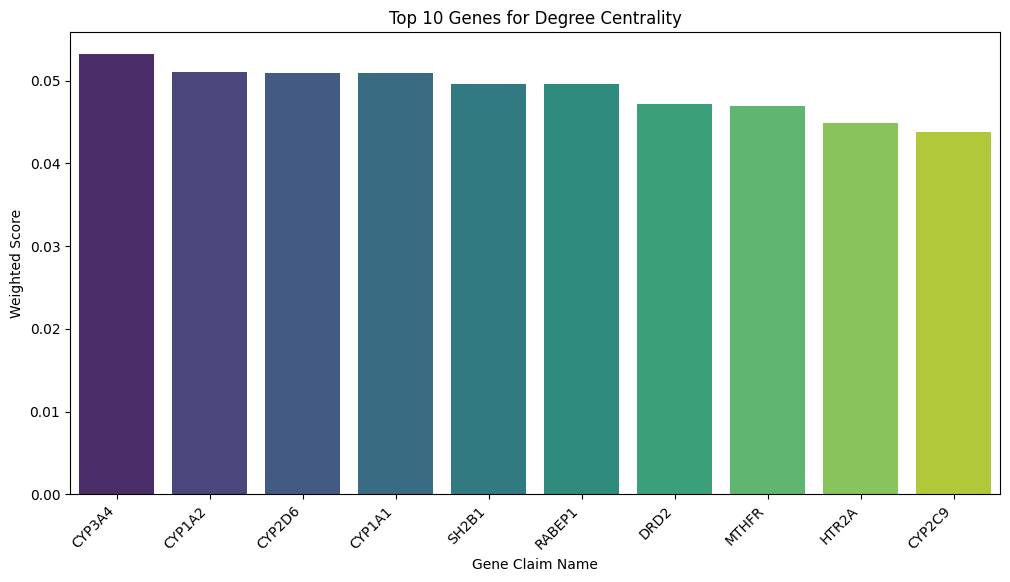

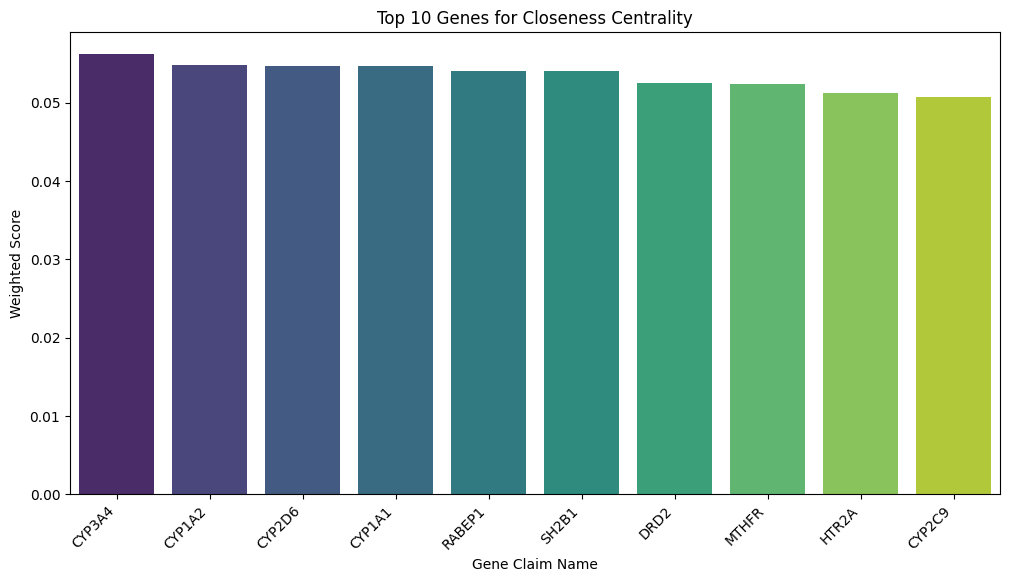

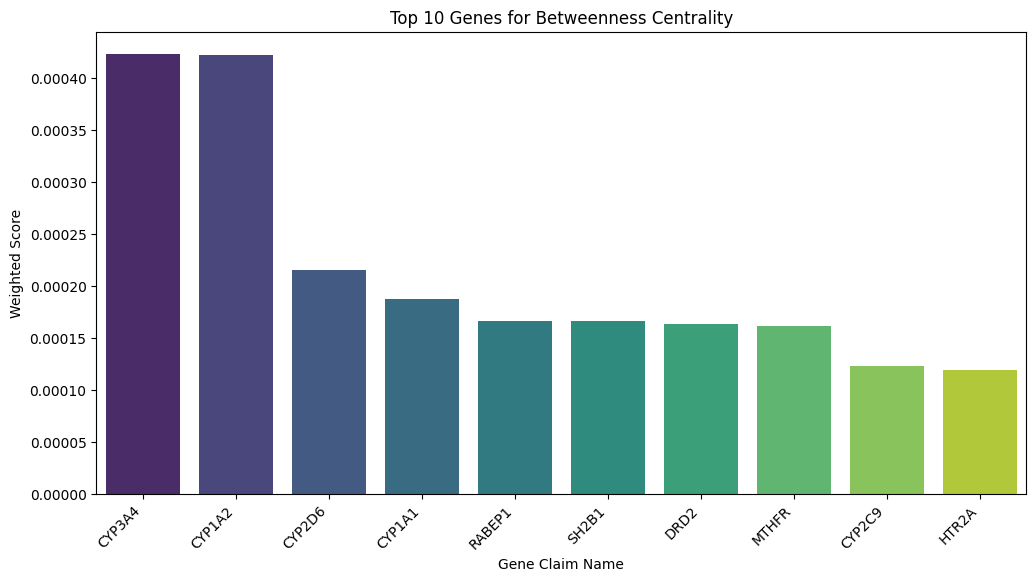

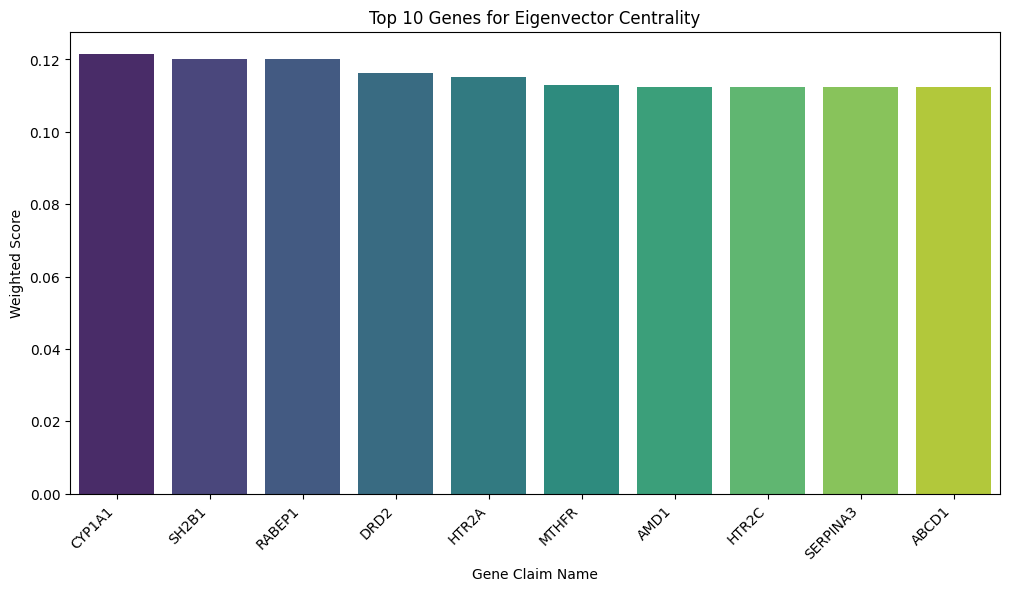

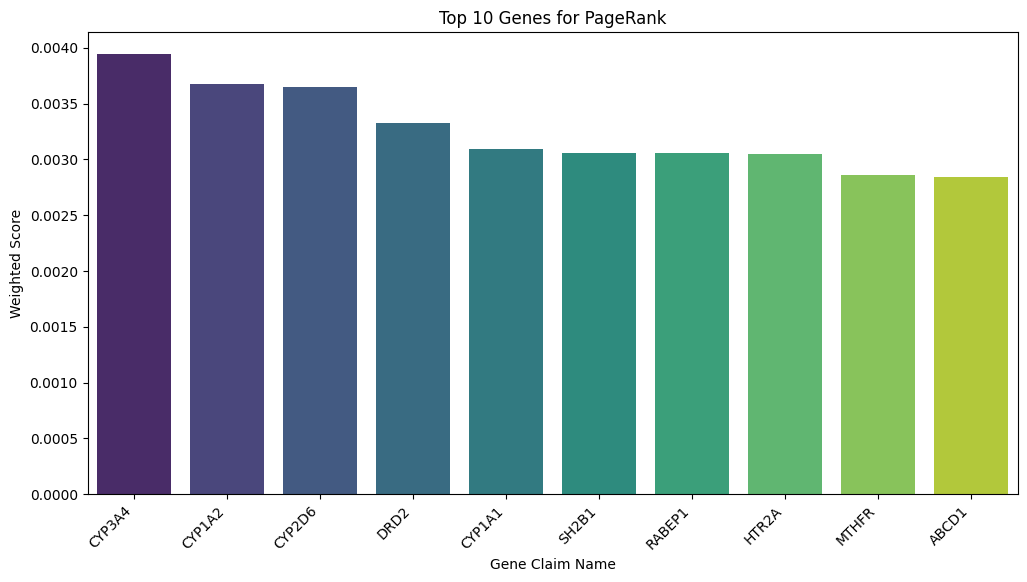

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot top 10 for each metric
def plot_top_10(df, title):
    df_top_10 = df.head(10)
    plt.figure(figsize=(12, 6))
    sns.barplot(x='claim_name', y='score', data=df_top_10, palette='viridis')
    plt.title(f'Top 10 Genes for {title}')
    plt.xlabel('Gene Claim Name')
    plt.ylabel('Weighted Score')
    plt.xticks(rotation=45, ha='right')
    plt.show()

# Plot for each centrality metric
plot_top_10(df_degree, 'Degree Centrality')
plot_top_10(df_closeness, 'Closeness Centrality')
plot_top_10(df_betweenness, 'Betweenness Centrality')
plot_top_10(df_eigenvector, 'Eigenvector Centrality')
plot_top_10(df_pagerank, 'PageRank')
